<a href="https://colab.research.google.com/github/Netesh5/Wheat_Disease_Detection/blob/main/wheatdiseasedetection_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import os

import tensorflow as tf


import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import callbacks
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.saving import save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
pip install pydot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install graphviz


Defaulting to user installation because normal site-packages is not writeable


In [ ]:


os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


In [ ]:
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable


## Dataset Loading and Feature Extraction

In [ ]:
#Python script that prints the current working directory.
import os
current_directory = os.getcwd()
print("Current Directory:", current_directory)


Current Directory: C:\code\wheat-project\traning


In [ ]:

def count_images_in_subfolders(main_folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']
    folder_image_counts = {}

    for folder in os.listdir(main_folder_path):
        folder_path = os.path.join(main_folder_path, folder)
        if os.path.isdir(folder_path):
            count = 0
            for file in os.listdir(folder_path):
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    count += 1
            folder_image_counts[folder] = count

    return folder_image_counts


main_dataset_folder = 'C:\\code\\wheat-project\\traning\\wheat_leaf'
image_counts = count_images_in_subfolders(main_dataset_folder)
img_count=[]
for folder, count in image_counts.items():
    img_count.append(count)
    print(f"Folder '{folder}': {count} images")



Folder 'Healthy Wheat': 882 images
Folder 'Leaf Rust': 820 images
Folder 'septoria': 856 images
Folder 'stripe_rust': 664 images
Folder 'Wheat___Brown_Rust': 902 images
Folder 'Wheat___Yellow_Rust': 924 images


## Images Size and Epochs value

In [ ]:
#he provided code snippet defines several constants typically used in the context of training neural networks,
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
#load data into tf dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "wheat_leaf",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5048 files belonging to 6 classes.


## Visualizing Distribution of Dataset

In [ ]:
#he code snippet you provided is related to fetching and displaying the class names from a dataset in a machine learning context
class_names = dataset.class_names
class_names

['Healthy Wheat',
 'Leaf Rust',
 'Wheat___Brown_Rust',
 'Wheat___Yellow_Rust',
 'septoria',
 'stripe_rust']

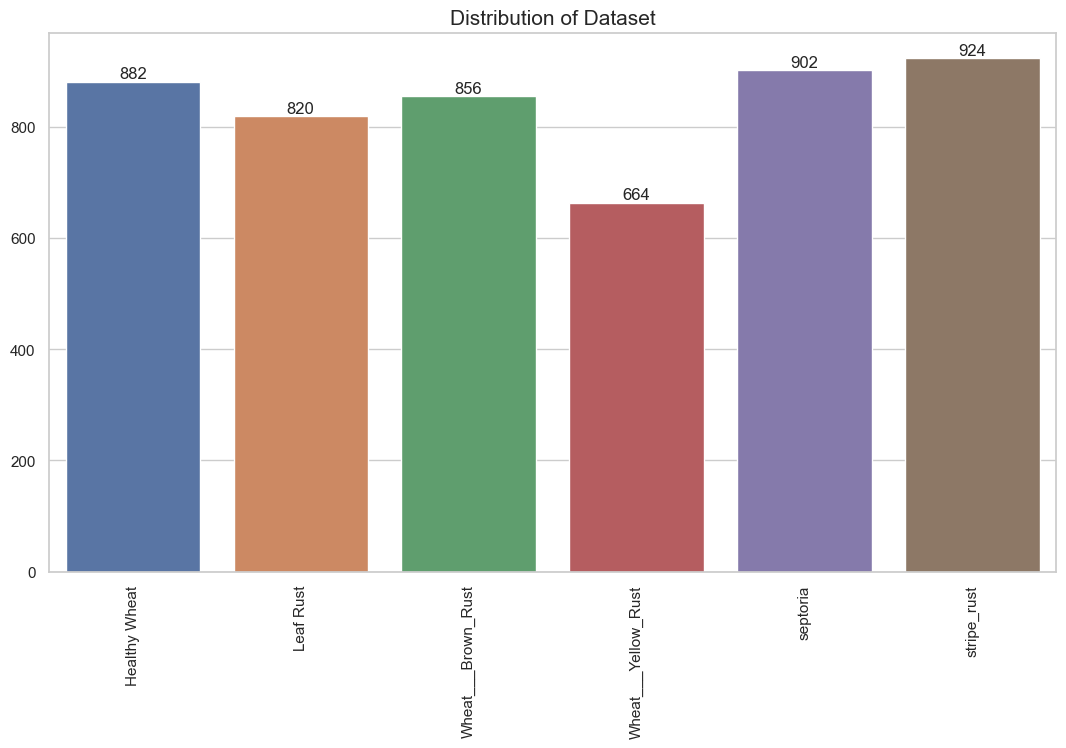

In [ ]:
#This code snippet creates a bar plot visualizing the distribution of images across different classes in a dataset using the seaborn and matplotlib libraries.
sns.set_theme(style="whitegrid")
plt.figure(figsize=(13,7))
ax = sns.barplot(x=class_names, y=img_count, hue=class_names)
for container in ax.containers:
  ax.bar_label(container)
plt.title("Distribution of Dataset", fontsize=15, fontweight=20)
plt.xticks(rotation=90)
plt.show()

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 3 0 0 2 3 4 0 2 3 2 4 2 4 0 3 0 3 1 0 1 1 3 2 2 3 5 2 2 1 3 0]


In [ ]:
#This code snippet is likely from a machine learning context where dataset is a batched dataset, such as one used in TensorFlow. The code iterates over the first batch of images and labels from the dataset and then prints information about them:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 3 4 1 4 1 4 0 1 5 4 1 1 4 3 0 3 0 2 1 4 3 3 5 5 3 0 4 3 2 1 0]


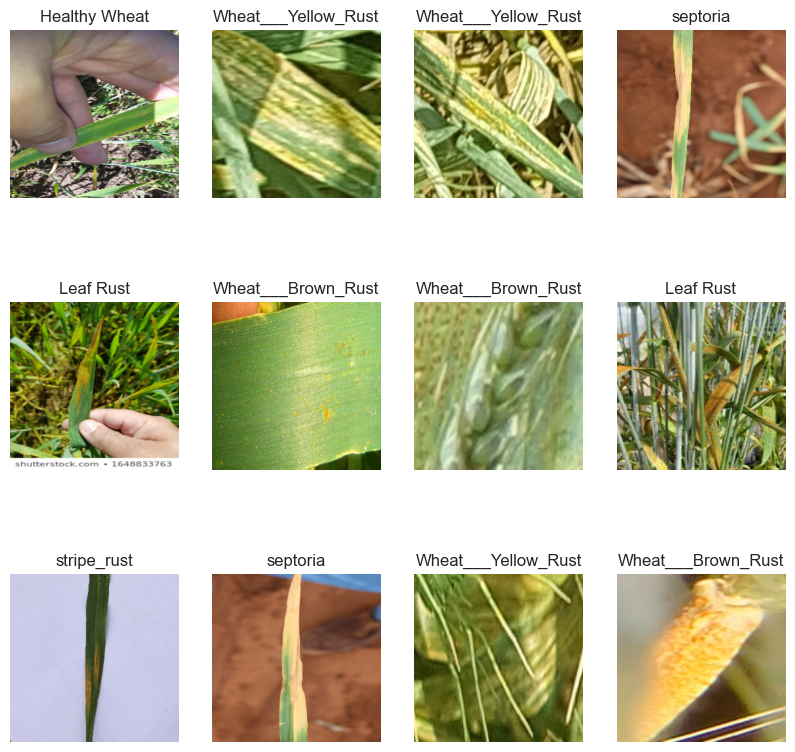

In [ ]:
#This code snippet creates a grid of subplots to display the first 12 images from the first batch of a dataset, along with their corresponding class labels.
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Seperation of Datasets into Training,Validation and Testing

In [ ]:
#The code len(dataset) is used to determine the number of batches in a dataset object, typically in a machine learning context.
len(dataset)

158

In [ ]:
#calculates the size of the training set as a fraction of the total dataset size in a machine learning context.
train_size = 0.8
len(dataset)*train_size

126.4

In [ ]:
train_ds = dataset.take(126)
len(train_ds)

126

In [ ]:
test_ds = dataset.skip(126)
len(test_ds)

32

In [ ]:
val_size=0.1
len(dataset)*val_size

15.8

In [ ]:
val_ds = test_ds.take(15)
len(val_ds)

15

In [ ]:
test_ds = test_ds.skip(15)
len(test_ds)

17

In [ ]:
# it isdesigned to split a dataset into training, validation, and test sets.
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

126

In [ ]:
len(val_ds)

15

In [ ]:
len(test_ds)

17

In [ ]:
#The provided code is a sequence of operations applied to the training (train_ds), validation (val_ds), and test datasets (test_ds) in a machine learning context,
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#The code snippet is a Python loop that processes the first batch of a dataset and then prints the pixel values of the first image in this batch after normalizing them.
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.7645221  0.8185049  0.38357842]
  [0.90083367 0.92886925 0.5027231 ]
  [0.8722606  0.90731704 0.4381684 ]
  ...
  [0.18136021 0.4203569  0.15455034]
  [0.17478028 0.4137597  0.14832944]
  [0.15257353 0.39178923 0.12120098]]

 [[0.7933211  0.82420343 0.39950982]
  [0.76123154 0.80325663 0.36163235]
  [0.794737   0.8513085  0.37940794]
  ...
  [0.19958963 0.4332413  0.1698843 ]
  [0.15537648 0.38955233 0.12652384]
  [0.1495098  0.3887255  0.11813726]]

 [[0.9939951  0.99699754 0.58547795]
  [0.87173986 0.8923817  0.46649075]
  [0.7698729  0.820566   0.3769701 ]
  ...
  [0.16965069 0.3971091  0.1354862 ]
  [0.14651442 0.38069028 0.11766178]
  [0.19301471 0.43223038 0.16164216]]

 ...

 [[0.9972426  0.9972426  0.9972426 ]
  [0.9951559  0.9951559  0.9951559 ]
  [0.99035347 0.99035347 0.99035347]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[0.98651963 0.98651963 0.98651963]
  [0.9944731  0.9944731  0.9944731 ]


In [ ]:
#it consists of two preprocessing layers for resizing and rescaling image data.
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
#data augemnation used in transforming the image it is used to to artificially expand the training dataset by applying random but realistic transformations to the training images
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Building CNN Model

## Building CNN Model

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
#This summary includes several details about the model's architecture,
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

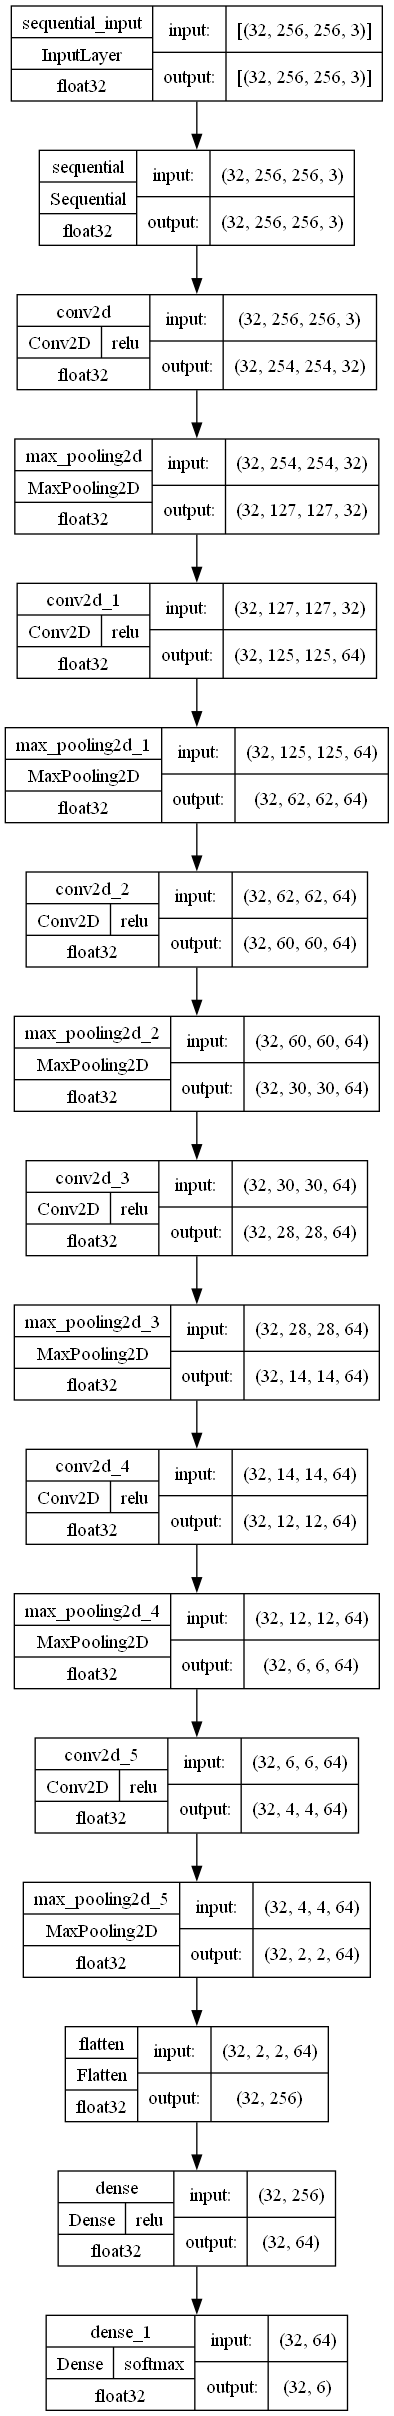

In [ ]:
#It's used to create a visual representation (plot) of a Keras mode
plot_model(model, to_file = "C:\\code\\wheat-project\\traning\\model.png", show_shapes = True,
           rankdir= 'TR', show_dtype = True, show_layer_activations= True)

In [ ]:
#The model.compile method is used to configure the model with the loss function, optimizer, and metrics.
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
#The code snippet is for training a neural network model using TensorFlow's Keras API.
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


126/126 [==============================] - 689s 4s/step - loss: 1.3193 - accuracy: 0.4451 - val_loss: 0.9592 - val_accuracy: 0.6479
Epoch 2/50
126/126 [==============================] - 329s 3s/step - loss: 0.8127 - accuracy: 0.6976 - val_loss: 0.6581 - val_accuracy: 0.7521
Epoch 3/50
126/126 [==============================] - 133s 1s/step - loss: 0.6112 - accuracy: 0.7746 - val_loss: 0.5262 - val_accuracy: 0.7958
Epoch 4/50
126/126 [==============================] - 126s 998ms/step - loss: 0.4604 - accuracy: 0.8370 - val_loss: 0.6193 - val_accuracy: 0.7937
Epoch 5/50
126/126 [==============================] - 124s 985ms/step - loss: 0.4226 - accuracy: 0.8477 - val_loss: 0.3234 - val_accuracy: 0.8875
Epoch 6/50
126/126 [==============================] - 118s 940ms/step - loss: 0.3640 - accuracy: 0.8723 - val_loss: 0.2670 - val_accuracy: 0.9104
Epoch 7/50
126/126 [==============================] - 119s 946ms/step - loss: 0.2642 - accuracy: 0.9046 - val_loss: 0.1851 - val_ac

In [ ]:
#is used to evaluate the performance of a trained Keras model on a test dataset using TensorFlow.
scores = model.evaluate(test_ds)

17/17 [==============================] - 371s 313ms/step - loss: 0.0556 - accuracy: 0.9908


In [ ]:
scores

[0.05563494563102722, 0.9908088445663452]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 126}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.4450795352458954,
 0.6975646018981934,
 0.7746024131774902,
 0.8369781374931335,
 0.8476639986038208,
 0.872266411781311,
 0.9045725464820862,
 0.9189860820770264,
 0.9301689863204956,
 0.9361332058906555,
 0.9502981901168823,
 0.9336481094360352,
 0.9498012065887451,
 0.9731610417366028,
 0.9609841108322144,
 0.9589959979057312,
 0.9609841108322144,
 0.9744035601615906,
 0.9696819186210632,
 0.9721670150756836,
 0.9890655875205994,
 0.9808648228645325,
 0.9649602174758911,
 0.9791252613067627,
 0.9910537004470825,
 0.97365802526474,
 0.9674453139305115,
 0.98384690284729,
 0.9977633953094482,
 0.9980119466781616,
 0.9992544651031494,
 0.9570079445838928,
 0.9831013679504395,
 0.97365802526474,
 0.98384690284729,
 0.9791252613067627,
 0.9860835075378418,
 0.9826043844223022,
 0.9893141388893127,
 0.9997515082359314,
 0.9997515082359314,
 0.9997515082359314,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

## Testing vs Validation Graph Plot

In [ ]:
#The provided code snippet extracts training and validation metrics from the history object, which is typically returned by the fit method of a Keras model in TensorFlow after training.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

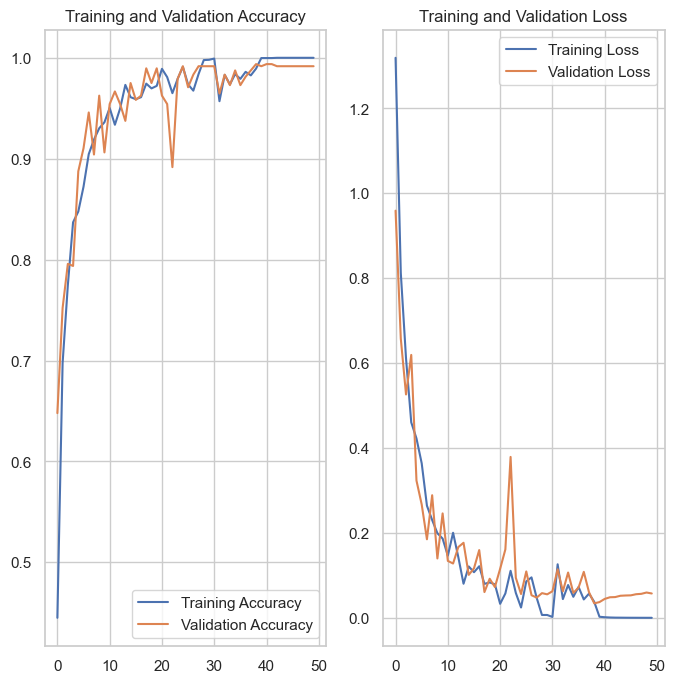

In [ ]:

#The provided code snippet creates a pair of plots using Matplotlib, a popular plotting library in Python. These plots display the training and validation accuracy and loss of a neural network model across epochs. The code is typically used to visualize the performance of the model during training, helping to identify trends such as overfitting or underfitting
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction

first image to predict
actual label: Healthy Wheat
1/1 [==============================] - 0s 217ms/step
predicted label: Healthy Wheat


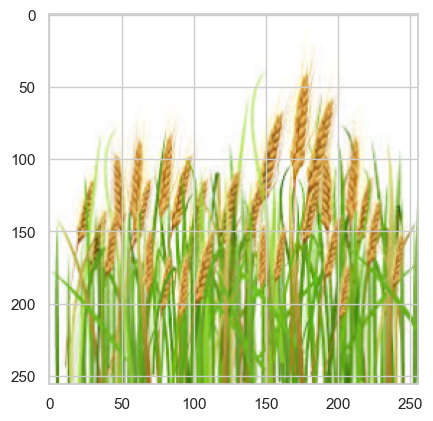

In [ ]:
#The provided code snippet demonstrates how to make predictions with a trained neural network model on a batch of images from the test dataset and visualize one of these images along with its actual and predicted labels.
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 60ms/step


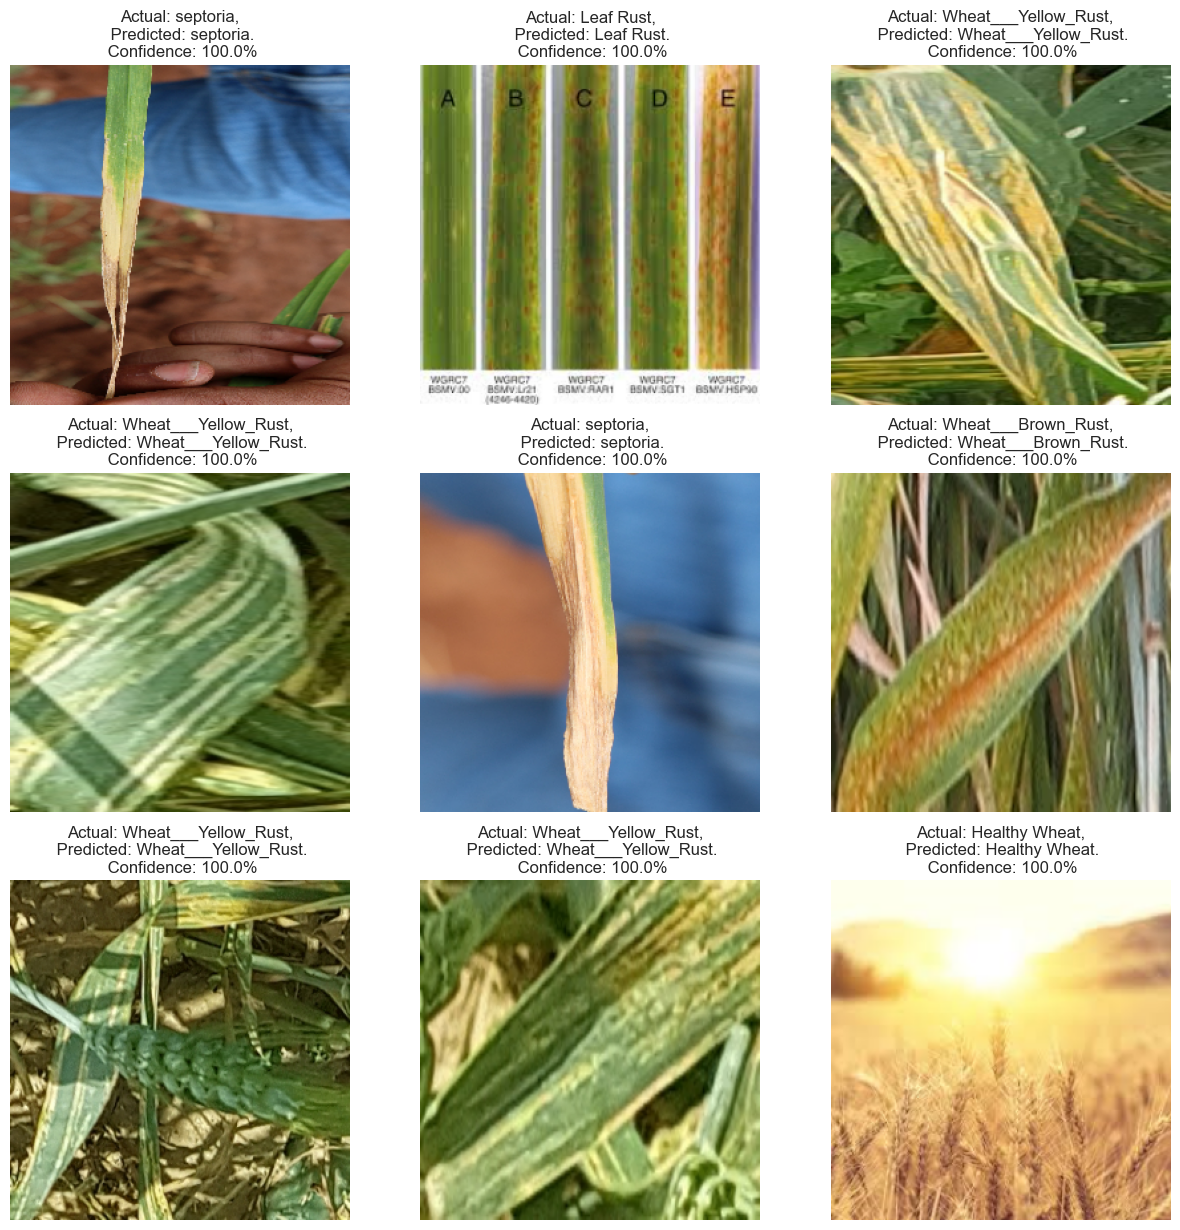

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


In [ ]:

import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model.save('wheatdiseasedetection.h5')

C:\Users\kusha\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Converting to TFlite Model

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('wheatdiseasedetection.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("wheatdisease.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\kusha\AppData\Local\Temp\tmpebvr6os7\assets


INFO:tensorflow:Assets written to: C:\Users\kusha\AppData\Local\Temp\tmpebvr6os7\assets


742604